# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "count_fingerprint_predictions_{0}.csv"

In [3]:
valid = pd.read_csv(DATA_PATH + FILE_PATTERN.format('valid'))
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [5]:
X_valid_mol = [Chem.MolFromSmiles(x) for x in valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [6]:
y_test = test.logp
y_valid = valid.logp

## Getting the data to compare

In [7]:
compare_data.head()

,smiles,y_expected,y_predicted
0,Cc1ccccc1C(C)C,4.38,3.606188
1,Clc1nc(-c2ccccc2)nc2ccccc12,4.47,4.130398
2,Cc1ccc(O)c(C(=O)O)c1,2.78,2.464271
3,O=c1[nH]c(O)c(-c2ccccc2)[nH]1,0.46,0.634567
4,CN(C)CCN1c2ccccc2Sc2ccccc21,4.20,3.624298


In [8]:
compare_data.shape

(1894, 3)

In [9]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [10]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,13.824134,155.354631
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.001741,17.654626
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,9.107111,13.011247
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,4.095806,11.873579
1823,Cn1ccc(=O)cc1,-1.22,1.108400,5.421447


In [11]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1559,CNC(=O)ON=C1SCOC1C(C)C,1.48,1.480044,1.948429e-09
649,ClCc1cccc(CCl)c1,2.72,2.719884,1.347399e-08
476,NNC(=O)c1cccc(Br)c1,1.26,1.259877,1.522530e-08
1869,CCOc1ccc(NC(=O)OCC(C)C)cc1OCC,3.36,3.359518,2.323496e-07
686,COC(=O)CC(=O)OC,-0.05,-0.049134,7.498928e-07


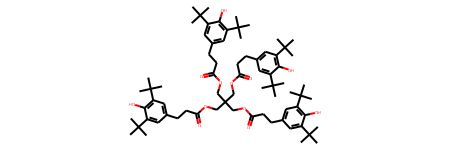

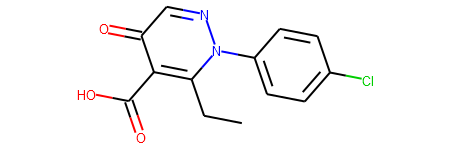

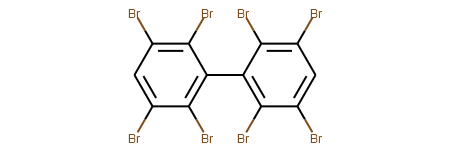

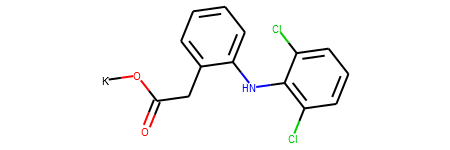

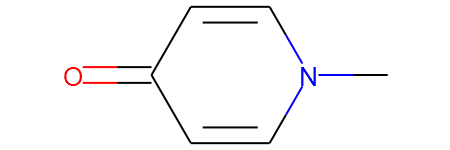

In [12]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

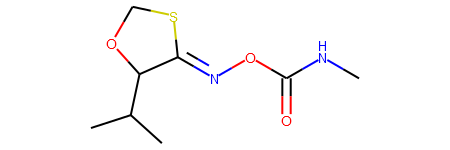

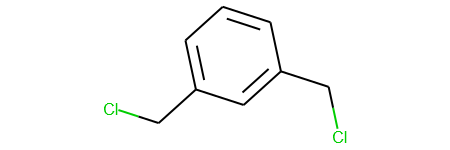

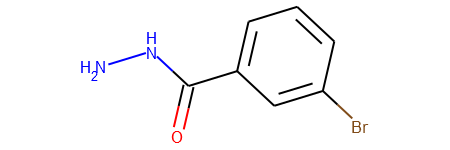

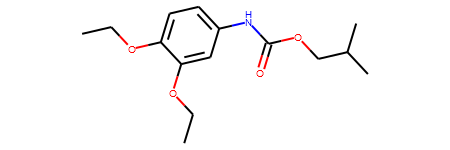

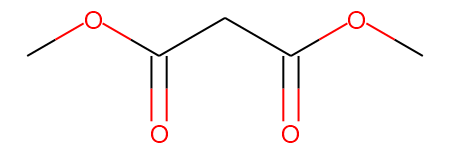

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [14]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [15]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [16]:
compare_data_with_stats = create_statistics(compare_data)

In [17]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1559,CNC(=O)ON=C1SCOC1C(C)C,1.48,1.480044,1.948429e-09,17,1,0,0.000000,1,100.0,14,0,0.000000,False
649,ClCc1cccc(CCl)c1,2.72,2.719884,1.347399e-08,17,2,7,41.176471,2,100.0,10,6,60.000000,False
476,NNC(=O)c1cccc(Br)c1,1.26,1.259877,1.522530e-08,22,2,0,0.000000,1,50.0,11,6,54.545455,False
1869,CCOc1ccc(NC(=O)OCC(C)C)cc1OCC,3.36,3.359518,2.323496e-07,16,1,1,6.250000,1,100.0,20,6,30.000000,False
686,COC(=O)CC(=O)OC,-0.05,-0.049134,7.498928e-07,8,1,0,0.000000,0,0.0,8,0,0.000000,True


#### Splitting data into 3 parts

In [18]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [19]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.064120,2.058210,7.453845e-03,16.526149,1.716323,0.852615,5.617791,0.860539,50.454305,16.822504,7.475436,45.400408
std,1.730597,1.734157,7.024045e-03,7.593786,1.131246,1.326945,8.924909,0.790547,42.835928,7.092375,4.386373,22.987338
min,-2.650000,-2.660112,1.948429e-09,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.830000,0.860997,1.363770e-03,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,1.890000,1.906213,5.132220e-03,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,2.955000,2.977613,1.224007e-02,20.000000,2.000000,1.000000,8.333333,1.000000,100.000000,20.000000,11.000000,60.000000
max,8.050000,8.167624,2.425039e-02,85.000000,8.000000,9.000000,80.000000,6.000000,100.000000,65.000000,27.000000,100.000000


In [20]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.060124,2.041567,0.070376,16.496038,1.667195,0.930269,5.995162,0.892235,54.815108,17.193344,7.012678,42.328026
std,1.829936,1.818827,0.033687,6.830806,1.057183,1.400075,9.375684,0.762902,42.605416,7.994682,4.422507,24.722635
min,-3.890000,-4.162690,0.024337,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.835000,0.814926,0.040320,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,27.777778
50%,1.830000,1.836193,0.064257,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,42.857143
75%,3.180000,3.130068,0.096436,20.000000,2.000000,1.000000,9.090909,1.000000,100.000000,20.500000,11.000000,60.000000
max,8.200000,8.413185,0.145534,56.000000,8.000000,9.000000,60.000000,5.000000,100.000000,61.000000,26.000000,100.000000


In [21]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.00000,632.000000
mean,1.988651,1.928693,0.886289,16.412975,1.651899,0.835443,5.445982,0.865506,52.092563,17.436709,7.18038,41.755537
std,1.881190,1.854164,6.252811,6.649144,1.102811,1.295418,8.860128,0.759064,42.658712,8.295023,4.72533,25.373219
min,-3.210000,-3.810878,0.145600,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.00000,0.000000
25%,0.690000,0.731102,0.220657,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.00000,27.777778
50%,1.845000,1.731296,0.362465,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,17.000000,6.00000,43.167702
75%,3.265000,2.942553,0.719844,19.000000,2.000000,1.000000,7.692308,1.000000,100.000000,21.000000,11.00000,59.444444
max,9.050000,13.824134,155.354631,56.000000,8.000000,8.000000,71.428571,5.000000,100.000000,88.000000,27.00000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [22]:
best = data[0].reset_index().drop(columns=['index'])

In [23]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CNC(=O)ON=C1SCOC1C(C)C,1.48,1.480044,1.948429e-09,17,1,0,0.000000,1,100.0,14,0,0.000000,False
1,ClCc1cccc(CCl)c1,2.72,2.719884,1.347399e-08,17,2,7,41.176471,2,100.0,10,6,60.000000,False
2,NNC(=O)c1cccc(Br)c1,1.26,1.259877,1.522530e-08,22,2,0,0.000000,1,50.0,11,6,54.545455,False
3,CCOc1ccc(NC(=O)OCC(C)C)cc1OCC,3.36,3.359518,2.323496e-07,16,1,1,6.250000,1,100.0,20,6,30.000000,False
4,COC(=O)CC(=O)OC,-0.05,-0.049134,7.498928e-07,8,1,0,0.000000,0,0.0,8,0,0.000000,True


In [24]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

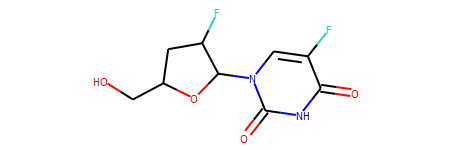

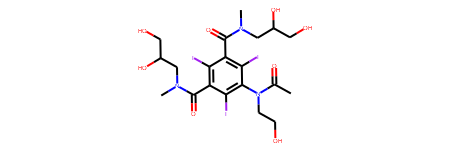

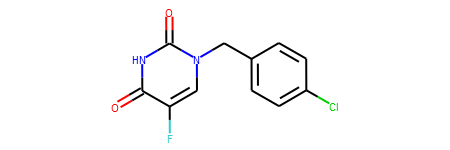

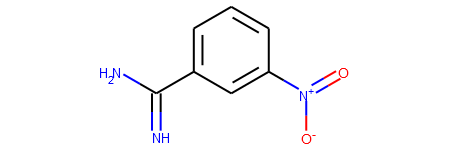

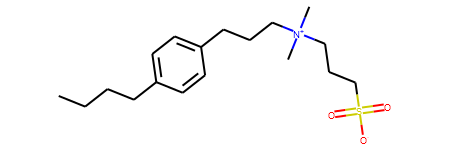

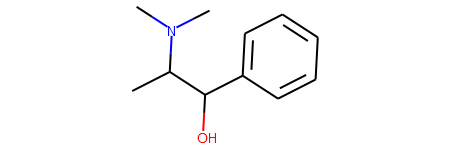

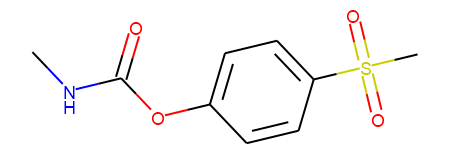

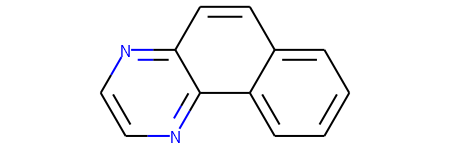

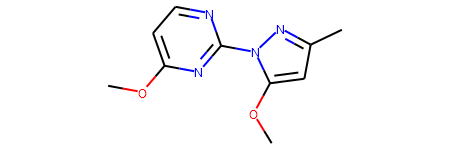

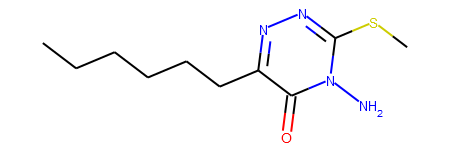

In [25]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [26]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [27]:
middle = data[1].reset_index().drop(columns=['index'])

In [28]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CN(C)Cc1ccccc1,1.98,1.823995,0.024337,10,0,4,40.000000,0,0.000000,10,6,60.000000,False
1,C=c1[nH]cc(CO)c(=CNNC(=O)c2ccco2)c1=O,1.39,1.233929,0.024358,18,2,1,5.555556,1,50.000000,21,11,52.380952,False
2,CCC(C(N)=O)n1nc2ccccc2n1,1.25,1.406213,0.024403,20,1,0,0.000000,1,100.000000,16,10,62.500000,False
3,CCCN(CCCC(NC(C)=O)C(=O)NCc1ccccc1)C(=O)N(C)N=O,1.61,1.766468,0.024482,28,3,0,0.000000,1,33.333333,28,6,21.428571,False
4,CCOC(=O)CCN(Cc1ccccc1)SN(C)C(=O)ON=C(C)SC,3.43,3.273194,0.024588,12,1,1,8.333333,1,100.000000,26,6,23.076923,False


In [29]:
middle.shape

(631, 14)

In [30]:
indices = pd.Series(np.random.randint(631, size=10))

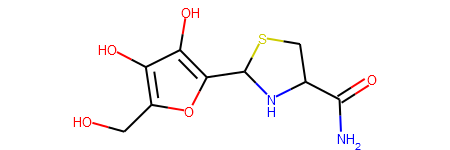

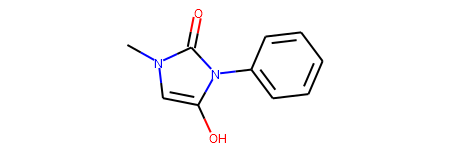

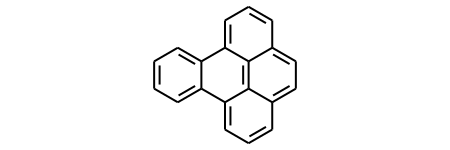

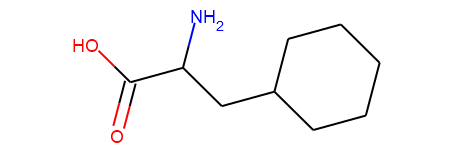

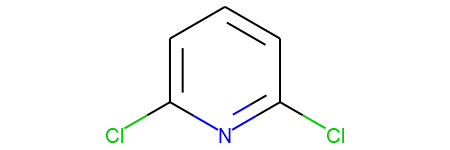

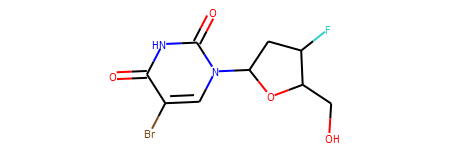

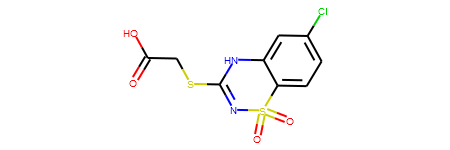

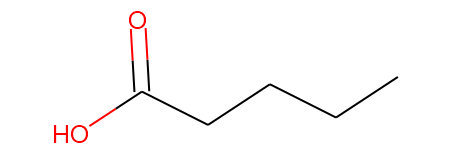

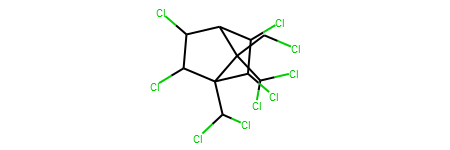

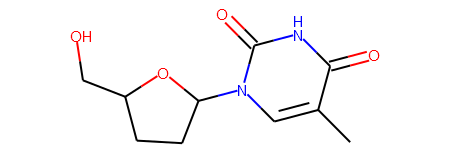

In [31]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [32]:
worst = data[2].reset_index().drop(columns=['index'])

In [33]:
indices = pd.Series(np.random.randint(631, size=10))

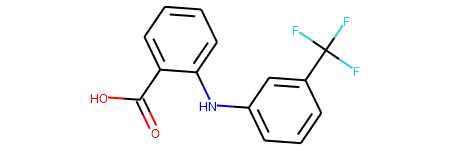

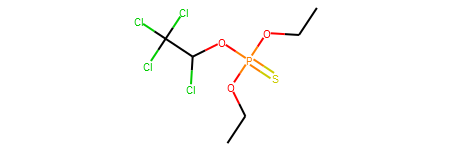

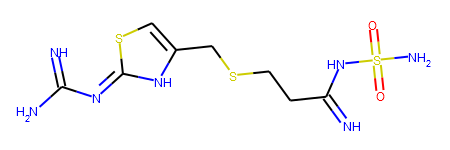

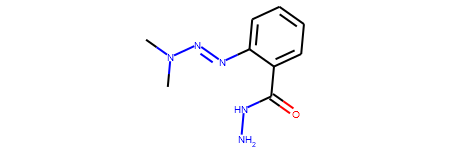

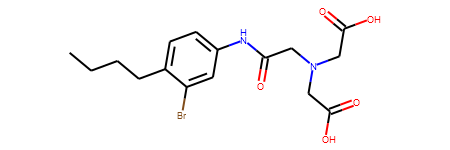

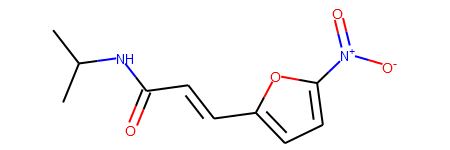

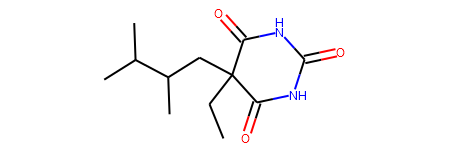

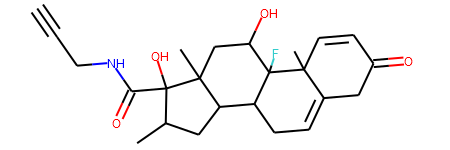

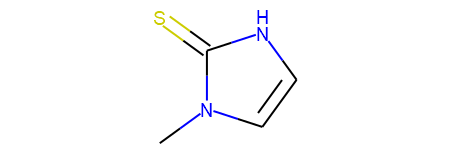

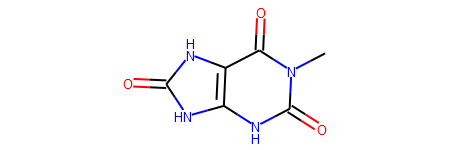

In [34]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [35]:
n_values = 200

In [36]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [37]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [38]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1559,CNC(=O)ON=C1SCOC1C(C)C,1.48,1.480044,1.948429e-09,17,1,0,0.000000,1,100.0,14,0,0.000000,False
649,ClCc1cccc(CCl)c1,2.72,2.719884,1.347399e-08,17,2,7,41.176471,2,100.0,10,6,60.000000,False
476,NNC(=O)c1cccc(Br)c1,1.26,1.259877,1.522530e-08,22,2,0,0.000000,1,50.0,11,6,54.545455,False
1869,CCOc1ccc(NC(=O)OCC(C)C)cc1OCC,3.36,3.359518,2.323496e-07,16,1,1,6.250000,1,100.0,20,6,30.000000,False
686,COC(=O)CC(=O)OC,-0.05,-0.049134,7.498928e-07,8,1,0,0.000000,0,0.0,8,0,0.000000,True


In [39]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,13.824134,155.354631,12,1,0,0.0,1,100.0,88,24,27.272727,True
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.001741,17.654626,11,1,0,0.0,1,100.0,20,12,60.000000,False
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,9.107111,13.011247,12,1,0,0.0,0,0.0,21,12,57.142857,True
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,4.095806,11.873579,20,1,2,10.0,1,100.0,21,12,57.142857,False
1823,Cn1ccc(=O)cc1,-1.22,1.108400,5.421447,17,2,0,0.0,2,100.0,8,6,75.000000,False


In [40]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.112100,2.114301,7.160349e-04,16.27000,1.760000,0.760000,5.118687,0.880000,49.183333,16.890000,7.120000,43.066421
std,1.833649,1.832963,6.467663e-04,8.20204,1.161527,1.148475,7.561585,0.853959,42.224239,7.869405,4.429867,23.000007
min,-2.650000,-2.660112,1.948429e-09,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.910000,0.906697,1.464388e-04,11.00000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,31.578947
50%,2.040000,2.036971,5.490718e-04,15.00000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,45.993590
75%,3.161250,3.148590,1.219438e-03,19.25000,2.000000,1.000000,8.083333,1.000000,100.000000,19.250000,10.250000,60.000000
max,7.910000,7.929572,2.071122e-03,85.00000,8.000000,7.000000,41.176471,6.000000,100.000000,65.000000,23.000000,85.714286


In [41]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.080512,1.977410,2.166913,16.830000,1.700000,0.755000,5.482174,0.825000,47.262500,18.205000,7.130000,38.814095
std,2.009821,2.049985,11.024204,7.773237,1.252134,1.171253,9.686722,0.829346,43.307667,9.347183,5.346591,27.204194
min,-3.210000,-2.622332,0.579651,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.640000,0.703008,0.754986,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,5.000000,16.607143
50%,2.010000,1.998356,1.028511,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,18.000000,6.000000,41.987179
75%,3.585000,3.026821,1.454296,20.000000,2.000000,1.000000,7.142857,1.000000,100.000000,22.000000,12.000000,57.142857
max,9.050000,13.824134,155.354631,56.000000,8.000000,5.000000,71.428571,5.000000,100.000000,88.000000,27.000000,100.000000


### Check atom_count influence

In [42]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-0.7008308582124507, pvalue=0.483818096248941)


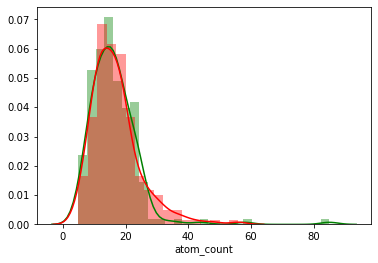

In [43]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [44]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=0.49682009770319135, pvalue=0.6195902279200209)


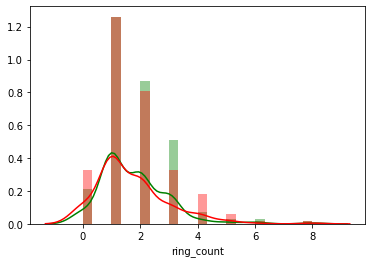

In [45]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [46]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.043106418465774364, pvalue=0.9656383203212985)


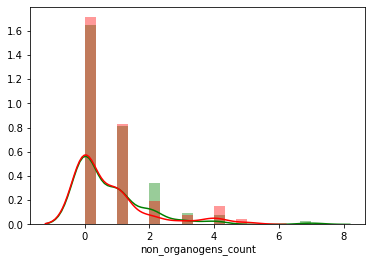

In [47]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [48]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=-0.41831192047068555, pvalue=0.6759446933962512)


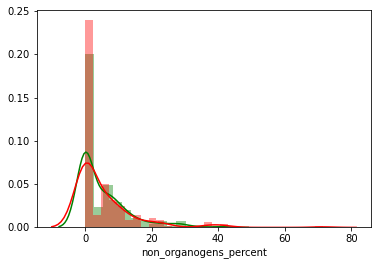

In [49]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [50]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=0.6534066069264002, pvalue=0.5138714748685096)


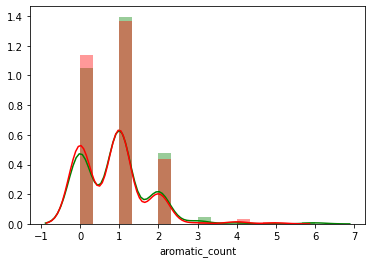

In [51]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [52]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=0.44911410061821705, pvalue=0.6535937989005332)


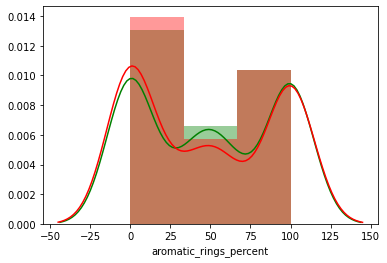

In [53]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [54]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=1.688103093193571, pvalue=0.092174803070026)


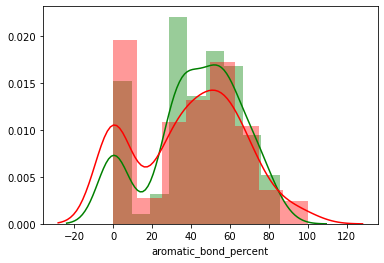

In [55]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [56]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-0.020367961425149447, pvalue=0.9837600486158631)


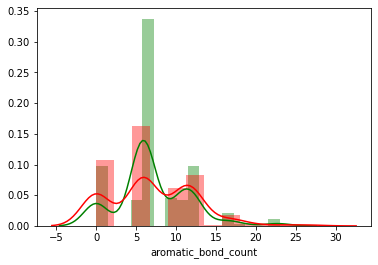

In [57]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

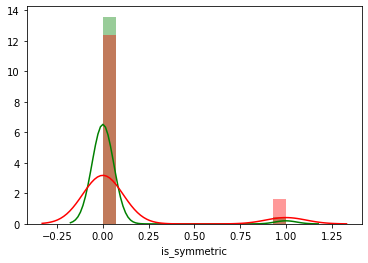

In [58]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [59]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [60]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [61]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [62]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [63]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [64]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [65]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.46889219600575166
Test symmetric R2-score is 0.921564566079313


In [66]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.5717247250477429
Test not symmetric R2-score is 0.9012648885800125
